In [1]:
import pandas as pd
import numpy
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append("..")
from utils import pad_collate
from dataloader_comma import CommaDataset
from dataloader_nuscenes import NUScenesDataset
from collections import Counter
import imageio
from model import VTN
import matplotlib.pyplot as plt 
from PIL import Image
import glob
plt.rcParams.update({'font.size': 26}) 
import os
from utils import * 
import re
from vis_utils import * 
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


/home/jessica/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using concept features


In [2]:
ckpt = torch.load(checkpoint_path, map_location=gpu)

In [ ]:
state_dict = ckpt['state_dict']
state_dict = get_regular_ckpt_from_lightning_checkpoint(state_dict)
model.load_state_dict(state_dict)
model.eval()
model = model.to(gpu)

In [ ]:
def split_string(string):
    words = string.replace("a photo of driving on a highway with", "").replace("a photo of", "").replace("driving on a highway", "").replace("past", "").replace("a street with", "").split()  # Split the string into a list of words
    result = []
    current_line = ""
    
    for word in words:
        if len(current_line) + len(word) <= 33:
            current_line += word + " "
        else:
            result.append(current_line.strip())
            current_line = word + " "
    
    if current_line:
        result.append(current_line.strip())
    
    return "\n".join(result)

torch.Size([1, 240, 3, 224, 224]) torch.Size([1, 240]) torch.Size([1, 240]) torch.Size([1, 240])


110it [04:32,  2.48s/it]


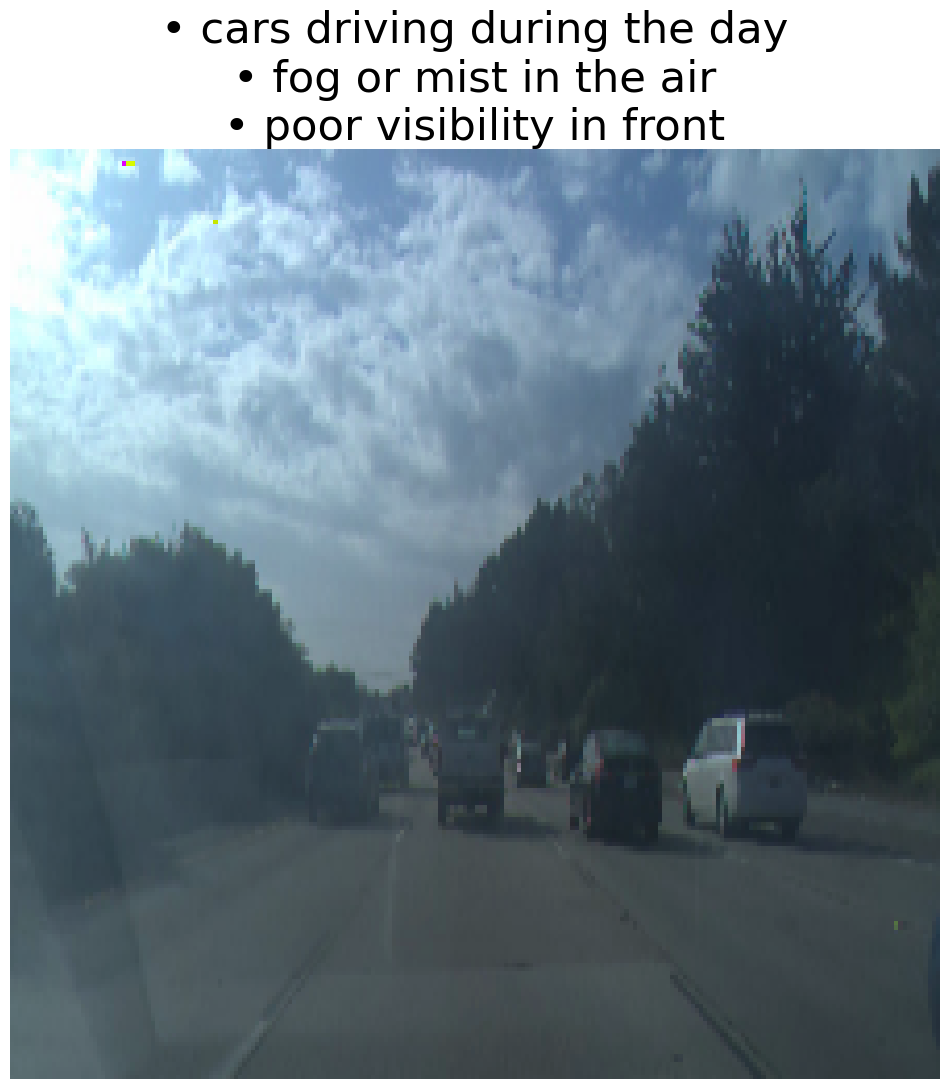

In [ ]:
for j, batch in enumerate(dataloader_comma):
    image_array,  vego, angle, distance, g, s, l = batch
    print(image_array.shape,  vego.shape, angle.shape, distance.shape)
    img = image_array
    max_len = 240
    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    (logits, attns), concepts = model(img, angle, distance, vego)
    top5_indices = torch.tensor(concepts.squeeze()).topk(10).indices
    s = img.shape
    angle, distance, vego, logits, concepts = angle.to("cpu"), distance.to("cpu"), vego.to("cpu"), logits.detach().cpu().to("cpu"), concepts.detach().cpu().to("cpu")
    
    f = []
    inter = []
    for i, elem0 in enumerate(top5_indices):
        inter = []
        for elem in top5_indices[max(i-20, 0):min(i+20,len(top5_indices))]:
            l = elem.cpu().numpy().tolist()
            if 131 in l:
                l.remove(131)
            if 55 in l:
                l.remove(55)
            inter.extend(l)
        count_dict = Counter(inter)
        # Get the top 5 most occurring numbers
        top_5 = count_dict.most_common(3)
        intermediate = []
        for a in top_5: 
            intermediate.append(scenarios[a[0]])
        f.append(intermediate)

    fig, axes = plt.subplots(1, 1, figsize=(12, 16))#,gridspec_kw= {'height_ratios': [20, 1]})

    plt_idx = 0
    for i, image in tqdm(enumerate(img[0][10:120])):
    
        image_frame = (image).cpu().permute(1, 2, 0)#unorm(image).cpu().permute(1, 2, 0)

        # Display the image frame
        axes.imshow((np.array(image_frame) * 255).astype(np.uint8))
        
        title = '\n'.join([split_string("\u2022 " + h) for h in f[i]])
        axes.set_title(title)
        axes.set_aspect('equal')
        axes.set_xticks([])
        axes.set_yticks([])

        # Remove borders
        axes.spines['top'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
        axes.spines['right'].set_visible(False)

        plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/mturk/{i}.png")

    
    image_directory = '/home/jessica/personalized_driving_toyota/result_images/mturk/'

    # Set the output GIF file path
    output_path = lambda x: f'/home/jessica/personalized_driving_toyota/result_images/mturk/att/attention_comma_{j}.{x}'

    # Set the duration (in milliseconds) for each frame in the GIF
    frame_duration = 700

    # Get a sorted list of image files in the directory
    image_files = sorted(glob.glob(f'{image_directory}/*.png'), key=extract_number)  # Adjust the file extension if necessary

    # Create a list to store the frames of the GIF
    frames = []

    # Iterate over each image file
    for image_file in image_files:
        # Open the image file
        image = Image.open(image_file)

        # Add the image to the list of frames
        frames.append(image)

    # Save the frames as a GIF
    frames[0].save(output_path("gif"), format='GIF', append_images=frames[1:], save_all=True,
                duration=frame_duration, loop=0)
    imageio.mimsave(output_path("mp4"), frames, fps=4)
    break
    if j > 50: break

In [6]:
pip install imageio[ffmpeg]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
for j, batch in enumerate(dataloader_comma):
    _, image_array, vego, angle, distance, m_lens, i_lens, s_lens, a_lens, d_lens = batch
    #if (j != 4) and (j != 8) and (j != 5):
    #    continue
    img = image_array
    max_len = 240
    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    (logits, attns), concepts = model(img, angle, distance, vego)
    top5_indices = torch.tensor(concepts.squeeze()).topk(5).indices
    s = img.shape
    angle, distance, vego, logits, concepts = angle.to("cpu"), distance.to("cpu"), vego.to("cpu"), logits.detach().cpu().to("cpu"), concepts.detach().cpu().to("cpu")

    atten = attns[0][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_0 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_0 = moving_average(speed_graph_0, 10)

    atten = attns[1][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_1 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_1 = moving_average(speed_graph_1, 10)

    print('kkk')

    atten = attns[2][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_2 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_2 = moving_average(speed_graph_2, 10)
    speed_graph = speed_graph_0 + speed_graph_1 + speed_graph_2
    #speed_graph = moving_average(speed_graph, 5)
    
    f = []
    inter = []
    for i, elem0 in enumerate(top5_indices):
        inter = []
        for elem in top5_indices[max(i-5, 0):min(i+5,len(top5_indices))]:
            l = elem.cpu().numpy().tolist()
            if 131 in l:
                l.remove(131)
            inter.extend(l)
        count_dict = Counter(inter)
        # Get the top 5 most occurring numbers
        top_5 = count_dict.most_common(2)
        intermediate = []
        for a in top_5: 
            intermediate.append(scenarios[a[0]])
        f.append(intermediate)

    fig, axes = plt.subplots(2, 8, figsize=(8, 16),gridspec_kw= {'height_ratios': [20, 1]})

    plt_idx = 0
    print('ggg')
    for i, image in enumerate(img[0][10:-10]): 
        #arr = [0, 15, 30, 55, 90, 145, 155, 185]
        #if i not in arr: continue
    
        image_frame = unorm(image).cpu().permute(1, 2, 0)

        # Display the image frame
        axes[0].imshow((np.array(image_frame) * 255).astype(np.uint8))
        
        title = '\n'.join([split_string("\u2022 " + h) for h in f[i]])
        axes[0][plt_idx].set_title(title)
        axes[0][plt_idx].set_aspect('equal')
        axes[0][plt_idx].set_xticks([])
        axes[0][plt_idx].set_yticks([])

        # Remove borders
        axes[0][plt_idx].spines['top'].set_visible(False)
        axes[0][plt_idx].spines['bottom'].set_visible(False)
        axes[0][plt_idx].spines['left'].set_visible(False)
        axes[0][plt_idx].spines['right'].set_visible(False)

        # Plot the speed graph
        #axes[1][plt_idx].plot(speed_graph_0[10:-10], label='Attention Head 1', color='black')
        #axes[1][plt_idx].plot(speed_graph_1[10:-10], label='Attention Head 2', color='blue')
        '''axes[1][plt_idx].plot(speed_graph_2[10:-10], label='Attention Head 3', color='green')
        if i == 0:
            axes[1][plt_idx].set_ylabel('Attention Activation')
            axes[1][plt_idx].set_xlabel(' ')

        if i == 5: 
            axes[1][plt_idx].set_xlabel('Time Step')'''

        #axes[1][plt_idx].plot(i, speed_graph_0[10:-10][i], marker='o', markersize=10, color='black')
        #axes[1][plt_idx].plot(i, speed_graph_1[10:-10][i], marker='o', markersize=10, color='blue')
        '''axes[1][plt_idx].plot(i, speed_graph_2[10:-10][i], marker='o', markersize=30, color='green')
        axes[1][plt_idx].spines['top'].set_visible(False)
        axes[1][plt_idx].spines['right'].set_visible(False)'''

        plt_idx +=1


        # Adjust the plot layout if necessary

        #arr = [0, 15, 20, 30, 55, 90, 145, 155, 185, 215]
        #if i in arr: 
        plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/mturk/{j}_{i}.pdf")
        #    plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/attention_2/{j}_{i}.png")
        #    plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/attention/{i}.png")
        #   plt_individual.append(fig)
        #plt.clf()
        #plt.close()
    #fig.subplots_adjust(wspace=0.15, hspace=0.01)
    #plt.tight_layout()
    #plt.subplots_adjust(top=0.85)
    #plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/mturk/attention_3/{j}.pdf")
    #plt.show()
    
    image_directory = '/home/jessica/personalized_driving_toyota/result_images/mturk/'

    # Set the output GIF file path
    output_path = lambda x: f'/home/jessica/personalized_driving_toyota/result_images/mturk/attention_comma_{j}.{x}'

    # Set the duration (in milliseconds) for each frame in the GIF
    frame_duration = 500

    # Get a sorted list of image files in the directory
    image_files = sorted(glob.glob(f'{image_directory}/*.png'), key=extract_number)  # Adjust the file extension if necessary

    # Create a list to store the frames of the GIF
    frames = []

    # Iterate over each image file
    for image_file in image_files:
        # Open the image file
        image = Image.open(image_file)

        # Add the image to the list of frames
        frames.append(image)

    # Save the frames as a GIF
    frames[0].save(output_path("gif"), format='GIF', append_images=frames[1:], save_all=True,
                duration=frame_duration, loop=0)
    imageio.mimsave(output_path("mp4"), frames, fps=30)  # Adjust the fps as needed
    '''normalized_weights = atten#np.array(attention_weights) / np.sum(attention_weights)

    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.pcolormesh(alignment_array[0:70, :], cmap='hot')
    # Add colorbar
    cbar = plt.colorbar(heatmap)

    # Add labels and title
    ax.set_xlabel('Sequence Position')
    ax.set_ylabel('Window')
    ax.set_title('Longformer Sliding Chunk Attention')

    # Show the plot
    #plt.savefig(f"/home/jessica/personalized_driving_toyota/attention_vis{j}.pdf")
    plt.close()'''
    break

    